In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

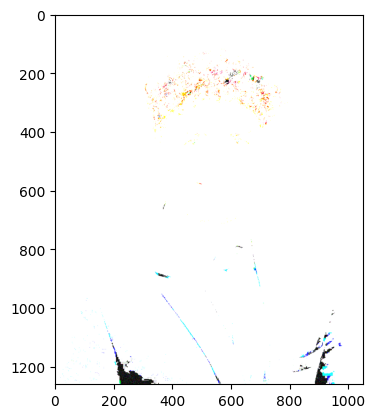

In [ ]:
image = tf.io.read_file("./DSC_7047.jpg")
image = tf.image.decode_jpeg(image)
image = tf.cast(image , tf.float32)

noisy_image = add_noise(image,0.05)
clipped_image = tf.clip_by_value(noisy_image, 0, 255)
plt.imshow(clipped_image)

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, Conv2DTranspose, Layer, Dense, Reshape, Add
from tensorflow.keras import Model
import math
import tensorflow as tf

class TimestepEmbedding(Layer):
    def __init__(self, dim=128, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim

    def call(self, timesteps):
        half_dim = self.dim // 2
        emb = math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, tf.float32) * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

def inject_timestep(x, t_emb, filters, name_suffix):
    """Projects timestep embedding and adds it to feature map"""
    # Project to match number of channels with a unique name
    t_proj = Dense(filters, name=f'time_proj_{filters}_{name_suffix}')(t_emb)  # [batch, filters]
    # Reshape to broadcast: [batch, filters] -> [batch, 1, 1, filters]
    t_proj = Reshape((1, 1, filters))(t_proj)
    # Add (broadcasts across spatial dimensions)
    return Add()([x, t_proj])

def diff_model():
    input_image = Input(shape=(32, 32, 3), name='image')
    input_timestep = Input(shape=(1,), name='timestep')

    # Timestep encoding ONCE
    t_emb = TimestepEmbedding(dim=128)(input_timestep)  # [batch, 128]

    # ENCODER
    X = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_image)
    X = BatchNormalization()(X)
    X = inject_timestep(X, t_emb, 32, 'enc1')  # INJECT HERE with unique suffix
    enc1 = X  # Save for skip connection

    X = Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = inject_timestep(X, t_emb, 64, 'enc2')  # INJECT HERE with unique suffix
    enc2 = X  # Save for skip connection

    X = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = inject_timestep(X, t_emb, 128, 'enc3')  # INJECT HERE with unique suffix

    # DECODER
    # Adjusted filters to 64 to match enc2
    X = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = inject_timestep(X, t_emb, 64, 'dec1')  # INJECT HERE with unique suffix
    X = Add()([X, enc2])  # Skip connection from encoder

    # Fix: Adjusted filters to 32 to match enc1
    X = Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = inject_timestep(X, t_emb, 32, 'dec2')  # INJECT HERE with unique suffix
    X = Add()([X, enc1])  # Skip connection from encoder

    X = Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = inject_timestep(X, t_emb, 32, 'dec3')  # INJECT HERE with unique suffix

    # Output: predicted NOISE (no activation on final layer!)
    outputs = Conv2D(filters=3, kernel_size=(3, 3), padding="same")(X) # Removed relu!

    model = Model(inputs=[input_image, input_timestep], outputs=outputs)
    return model

# Test
model = diff_model()
print("✅ Model created successfully!")
model.summary()

# Test inference
import numpy as np
test_img = np.random.randn(2, 32, 32, 3).astype(np.float32)
test_t = np.array([[350], [720]]).astype(np.float32)
output = model([test_img, test_t])
print(f"\n✅ Forward pass works! Output shape: {output.shape}")

✅ Model created successfully!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestep            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 32, 32, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ timestep_embedding… │ (None, 128)       │          0 │ timestep[0][0]    │
│ (TimestepEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │        896 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_proj_32_enc1   │ (None, 32)        │      4,128 │ timestep_embeddi… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1, 1, 32)  │          0 │ time_proj_32_enc… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │     51,264 │ add_20[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_proj_64_enc2   │ (None, 64)        │      8,256 │ timestep_embeddi… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_16          │ (None, 1, 1, 64)  │          0 │ time_proj_64_enc… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_proj_128_enc3  │ (None, 128)       │     16,512 │ timestep_embeddi… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_17          │ (None, 1, 1, 128) │          0 │ time_proj_128_en… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 307,971 (1.17 MB)

 Trainable params: 307,267 (1.17 MB)

 Non-trainable params: 704 (2.75 KB)


✅ Forward pass works! Output shape: (2, 32, 32, 3)


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pixel-art' dataset.
Path to dataset files: /kaggle/input/pixel-art


In [ ]:
import os
image_list = os.listdir(f"{path}/images/images")
tf_ds = tf.data.Dataset.from_tensor_slices(image_list)

In [ ]:

import tensorflow as tf
import numpy as np

# CRITICAL: Define noise schedule (beta schedule)
def get_beta_schedule(timesteps=1000):
    """Linear schedule from DDPM paper"""
    beta_start = 0.0001
    beta_end = 0.02
    return np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)

betas = get_beta_schedule(1000)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas)  # This is what we actually use!

# Convert to tensors for fast lookup
alphas_cumprod_tf = tf.constant(alphas_cumprod, dtype=tf.float32)

def add_noise(img, t):
    """
    img: clean image [H, W, C], values in [0, 1]
    t: timestep integer (0 to 999)
    returns: noisy image, actual noise added
    """
    # Look up alpha for this timestep
    alpha_t = tf.gather(alphas_cumprod_tf, t)

    # Generate random noise
    noise = tf.random.normal(tf.shape(img))

    # Add noise using DDPM formula: sqrt(alpha_t) * x + sqrt(1 - alpha_t) * noise
    sqrt_alpha_t = tf.sqrt(alpha_t)
    sqrt_one_minus_alpha_t = tf.sqrt(1.0 - alpha_t)

    noisy_img = sqrt_alpha_t * img + sqrt_one_minus_alpha_t * noise

    return noisy_img, noise

def preprocess_ds(filename):
    # Load and decode image
    image = tf.io.read_file("/kaggle/input/pixel-art/images/images/" + filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_crop_or_pad(image, 32, 32)

    # NORMALIZE to [0, 1] range!
    image = tf.cast(image, dtype=tf.float32) / 255.0

    # Sample random timestep (INTEGER from 0 to 999)
    timestep = tf.random.uniform((), minval=0, maxval=1000, dtype=tf.int32)

    # Add noise
    noisy_img, noise = add_noise(image, timestep)

    # Return format: (inputs, target)
    # inputs = (noisy_image, timestep)
    # target = noise (what model should predict)
    return (noisy_img, tf.cast(timestep, tf.float32)), noise

# Create dataset
import os
filenames = os.listdir("/kaggle/input/pixel-art/images/images/")
tf_ds = tf.data.Dataset.from_tensor_slices(filenames)
tf_ds = tf_ds.map(preprocess_ds).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model.compile("adam", tf.keras.losses.MSE , metrics = ['accuracy'])
model.fit(tf_ds)

2794/2794 ━━━━━━━━━━━━━━━━━━━━ 1088s 386ms/step - accuracy: 0.9560 - loss: 0.0290


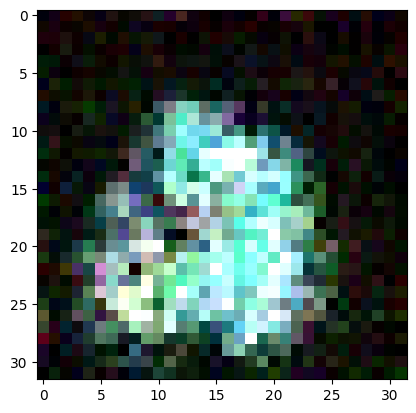

In [ ]:
for t in reversed(range(1, 300)):
    t_input = tf.constant([[float(t)]])
    predicted_noise = model([x, t_input])

    alpha_t = alphas[t]
    alpha_bar_t = alphas_cumprod[t]
    beta_t = betas[t]

    x = (
        1.0 / tf.sqrt(alpha_t) *
        (x - ((beta_t / tf.sqrt(1 - alpha_bar_t)) * predicted_noise))
    )

    if t > 1:
        noise = tf.random.normal(tf.shape(x))
        x = x + tf.sqrt(beta_t) * noise

# Clip final image
x = tf.clip_by_value(x, 0, 1)
plt.imshow(tf.squeeze(x,axis=0))
